In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
from torchvision.utils import save_image
from torchsummary import summary


In [ ]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)


In [ ]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [ ]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512, 512]
num_epochs = 20
batch_size = 200
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
norm_layer = None
print(hidden_size)

[128, 512, 512, 512, 512, 512]


In [ ]:
#################################################################################
# TODO: Chose the right data augmentation transforms with the right        #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################
data_aug_transforms = []
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Ex3/datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Ex3/datasets/',
                                          train=False,
                                          transform=test_transform
                                          )

Files already downloaded and verified


In [ ]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [ ]:
#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
#-------------------------------------------------
# Convolutional neural network
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # make use of conv2d and relu layers from the torch.nn module.         #
        # make use of BatchNorm2d layer from the torch.nn module.              #
        # Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, hidden_layers[0], kernel_size=3, stride=1, padding=1), #input: 3 x 32 x 32
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 128 x 16 x 16

        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_layers[0], hidden_layers[1], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 8 x 8

        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_layers[1], hidden_layers[2], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 4 x 4

        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_layers[2], hidden_layers[3], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 2 x 2

        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_layers[3], hidden_layers[4], kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU()) # output: 512 x 1 x 1

        self.fc1 = nn.Linear(hidden_layers[5], 10)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [ ]:
#-------------------------------------------------
# Calculate the model size 
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    #model_sz = sum([np.prod(p.size()) for p in model_parameters])
    model_sz = sum(q.numel() for q in model.parameters() if q.requires_grad)
    if disp == True: 
      print(model_sz)
    else:
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      return model_sz

In [ ]:
def VisualizeFilter(model):

  # get the kernels from the first layer 
  kernels = model.cpu().conv1[0].weight.detach().clone()

  #check size for sanity check
  print(kernels.size())

  # normalize to (0,1) range so that matplotlib can plot them
  kernels = kernels - kernels.min()
  kernels = kernels / kernels.max()
  filter_img = torchvision.utils.make_grid(kernels, nrow = 16)

  # change ordering since matplotlib requires images to be (H, W, C)
  plt.figure(figsize=(16, 8))
  plt.imshow(filter_img.permute(1, 2, 0))


In [ ]:
#======================================================================================
# Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)

In [ ]:
# Initialize the model with correct batch norm layer

model.apply(weights_init)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [ ]:
# Print model size
#======================================================================================
# Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)

7678474


torch.Size([128, 3, 3, 3])


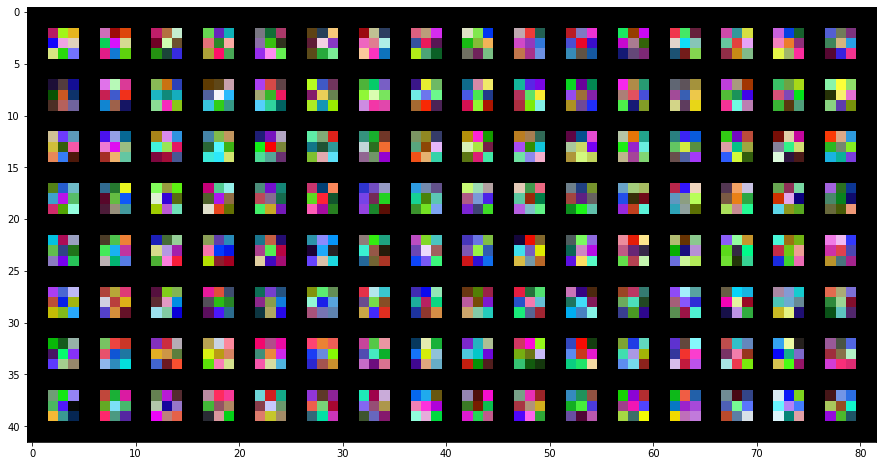

In [ ]:
#======================================================================================
# Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
#======================================================================================
VisualizeFilter(model)


In [ ]:
if torch.cuda.is_available():
    model.cuda()

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

In [ ]:
# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_history = []
val_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_history.append(running_loss / len(train_dataset))

    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_acc.append(100 * correct / total)
        
        print('Validataion accuracy is: {} %'.format(100 * correct / total))

    model.train()

Epoch [1/20], Step [100/245], Loss: 1.6872
Epoch [1/20], Step [200/245], Loss: 1.2512
Validataion accuracy is: 51.3 %
Epoch [2/20], Step [100/245], Loss: 1.1082
Epoch [2/20], Step [200/245], Loss: 0.9329
Validataion accuracy is: 65.1 %
Epoch [3/20], Step [100/245], Loss: 0.8105
Epoch [3/20], Step [200/245], Loss: 0.8719
Validataion accuracy is: 70.2 %
Epoch [4/20], Step [100/245], Loss: 0.6897
Epoch [4/20], Step [200/245], Loss: 0.7370
Validataion accuracy is: 76.0 %
Epoch [5/20], Step [100/245], Loss: 0.6915
Epoch [5/20], Step [200/245], Loss: 0.5746
Validataion accuracy is: 74.4 %
Epoch [6/20], Step [100/245], Loss: 0.5948
Epoch [6/20], Step [200/245], Loss: 0.5318
Validataion accuracy is: 76.1 %
Epoch [7/20], Step [100/245], Loss: 0.4429
Epoch [7/20], Step [200/245], Loss: 0.4901
Validataion accuracy is: 80.0 %
Epoch [8/20], Step [100/245], Loss: 0.4501
Epoch [8/20], Step [200/245], Loss: 0.4144
Validataion accuracy is: 77.7 %
Epoch [9/20], Step [100/245], Loss: 0.4455
Epoch [9/20],

<function matplotlib.pyplot.show>

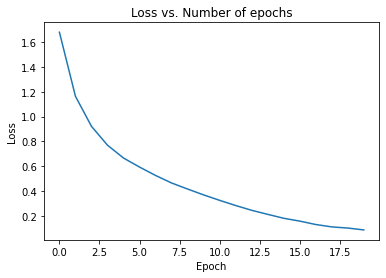

In [ ]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Number of epochs');
plt.show

<function matplotlib.pyplot.show>

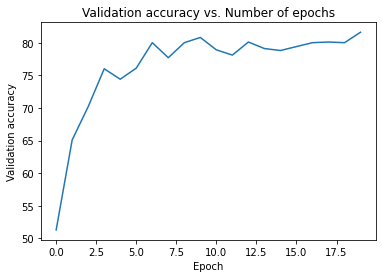

In [ ]:
plt.plot(val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy vs. Number of epochs');
plt.show

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Accuracy of the network on the 1000 test images: 80.6 %


torch.Size([128, 3, 3, 3])


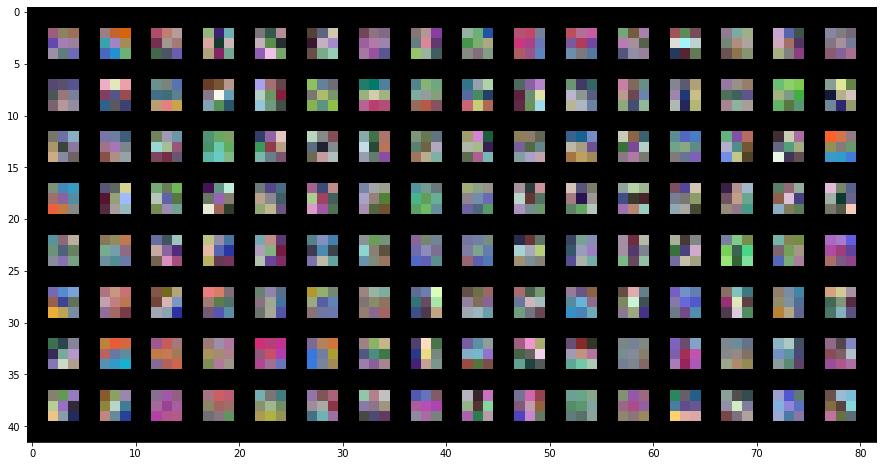

In [ ]:
# Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
VisualizeFilter(model)
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')